## Requirements

### Imports

In [22]:
import os
import torch
from pathlib import Path

import random
import torch
import torchcam
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchcam.methods import GradCAM
from torchvision import transforms

In [23]:
import training

In [ ]:
torch.manual_seed(42)

### Paths

In [25]:
SRC_DIR = Path.cwd()
ROOT_DIR = SRC_DIR.parent

DATA_DIR = os.path.join(ROOT_DIR, 'dataset')
PREPROCESSED_DIR = os.path.join(DATA_DIR, 'preprocessed')
CSV_PATH = os.path.join(DATA_DIR, 'csv_mappings', 'train.csv')

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
BASELINE_DIR = os.path.join(MODEL_DIR, 'baselines')
BASELINE_FINETUNED_DIR = os.path.join(MODEL_DIR, 'baselines_finetuned')
RESULT_DIR = os.path.join(BASELINE_DIR, 'results')

### Load Data

In [26]:
BATCH_SIZE = 32

In [27]:
CLASS_NAMES = {
    0: "amanita",
    1: "boletus",
    2: "chantelle",
    3: "deterrimus",
    4: "rufus",
    5: "torminosus",
    6: "aurantiacum",
    7: "procera",
    8: "involutus",
    9: "russula"
}

In [28]:
train_loader, val_loader, test_loader = training.get_data_loaders(PREPROCESSED_DIR, CSV_PATH, BATCH_SIZE)

##### Set model to explain

In [29]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 10 

In [30]:
model_type = 'resnet'  
# alexnet # resnet # vgg16 # densenet # efficientnet
# custom_alexnet custom_resnet

In [ ]:
model = training.load_model_for_explaining(model_type, NUM_CLASSES, DEVICE, finetuned=True)

### Explain

In [98]:
def unnormalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

def show_random_image(test_loader, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    random_index = random.randint(0, len(test_loader.dataset) - 1)
    image, label = test_loader.dataset[random_index]
    image = unnormalize(image.clone(), mean, std)
    original_image = image.cpu().numpy().transpose(1, 2, 0)

    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    return image, label

In [99]:
def integrated_gradients(model, image, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(image)
    
    interpolated_images = [(baseline + (float(i) / steps) * (image - baseline)) for i in range(steps + 1)]
    interpolated_images = torch.stack(interpolated_images).to(image.device)
    interpolated_images = interpolated_images.squeeze(1)
    
    batch_size = interpolated_images.shape[0]
    interpolated_images = interpolated_images.view(batch_size, 3, 224, 224)

    interpolated_images.requires_grad = True
    model.zero_grad()
    
    outputs = model(interpolated_images)
    target = outputs[:, target_class]
    target.backward(torch.ones_like(target), retain_graph=True)

    gradients = interpolated_images.grad
    integrated_gradients = (image - baseline) * gradients.mean(dim=0)
    
    return integrated_gradients

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_integrated_gradients(model, image, label, integrated_gradients_func, device):
    image_tensor = image.unsqueeze(0).to(device)
    target_class = label.item()

    attributions = integrated_gradients_func(model, image_tensor, target_class)
    attributions = attributions.squeeze().cpu().numpy()
    attributions = np.abs(attributions)

    attributions_min = np.min(attributions)
    attributions_max = np.max(attributions)
    attributions = (attributions - attributions_min) / (attributions_max - attributions_min)

    original_image = image.cpu().numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Attribution maps for (R, G, B)
    for i, ax in enumerate(axes[1:]):
        ax.imshow(attributions[i], cmap='hot')
        ax.set_title(f'Channel {i+1} Attribution')
        ax.axis('off')

    plt.show()


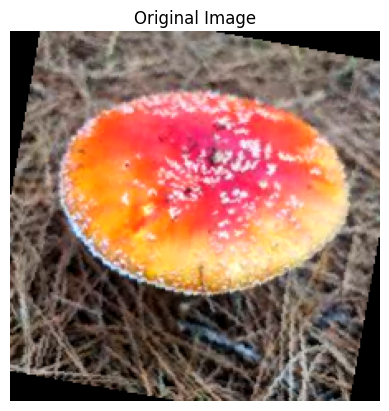

In [101]:
image, label = show_random_image(test_loader)


In [ ]:
visualize_integrated_gradients(model, image, label, integrated_gradients, DEVICE)
